# Final Project
## 使用Python进行电影票房分析
### 数据集: kaggle上的TMDB 5000 Movie Dataset [link](https://www.kaggle.com/tmdb/tmdb-movie-metadata)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

In [2]:
movies = pd.read_csv('datas/tmdb_5000_movies.csv')
credits = pd.read_csv('datas/tmdb_5000_credits.csv')

In [3]:
print(movies.columns)
print(credits.columns)

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')
Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')


In [4]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [5]:
credits.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [6]:
assert len(movies) == len(credits)
print(f'movie number: {len(movies)}')

movie number: 4803


#### 合并两张数据表


In [7]:
all_data = pd.concat([credits, movies], axis=1)

In [8]:
# 筛选有用的信息
movies_df = all_data[['movie_id', 'original_title', 'budget', 'genres', 'keywords', 
                      'original_language', 'popularity', 'release_date', 'revenue',
                     'vote_average', 'vote_count']]
# relase data 有一个为 null，去除
movies_df = movies_df.loc[~movies_df['release_date'].isnull()]

In [9]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4802
Data columns (total 11 columns):
movie_id             4802 non-null int64
original_title       4802 non-null object
budget               4802 non-null int64
genres               4802 non-null object
keywords             4802 non-null object
original_language    4802 non-null object
popularity           4802 non-null float64
release_date         4802 non-null object
revenue              4802 non-null int64
vote_average         4802 non-null float64
vote_count           4802 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 450.2+ KB


In [10]:
movies_df.head(2)

,movie_id,original_title,budget,genres,keywords,original_language,popularity,release_date,revenue,vote_average,vote_count
0,19995,Avatar,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,150.437577,2009-12-10,2787965087,7.2,11800
1,285,Pirates of the Caribbean: At World's End,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,139.082615,2007-05-19,961000000,6.9,4500


In [11]:
# 处理 genres, keywords, release_date 数据
def extract_data(x):
    return ','.join([i['name'].strip() for i in x])
def get_year(x):
    return x.split('-')[0]

In [12]:
for w in ['genres', 'keywords']:
    movies_df[w] = movies_df[w].apply(json.loads).apply(extract_data).copy()

In [13]:
movies_df['release_date'] = movies_df['release_date'].apply(get_year)

In [14]:
genres = []
for i in movies_df['genres'].str.split(','):
    genres += i
genres = sorted(list(set(genres)))
genres.remove('')

In [15]:
print(genres)

['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']


In [16]:
for g in genres:
    movies_df[g] = movies_df['genres'].str.contains(g).apply(lambda x: 1 if x else 0)
movies_df.head(1)

,movie_id,original_title,budget,genres,keywords,original_language,popularity,release_date,revenue,vote_average,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,19995,Avatar,237000000,"Action,Adventure,Fantasy,Science Fiction","culture clash,future,space war,space colony,so...",en,150.437577,2009,2787965087,7.2,...,0,0,0,0,0,1,0,0,0,0


In [17]:
genres_df = movies_df[['release_date', 'budget', 'revenue']+genres].copy()

In [18]:
genres_year = genres_df.groupby('release_date').sum()
genres_year.head(2)

,budget,revenue,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
release_date,,,,,,,,,,,,,,,,,,,,,
1916,385907,8394751,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1925,245000,22000000,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


# 每种流派电影的数量随时间的变化趋势分析

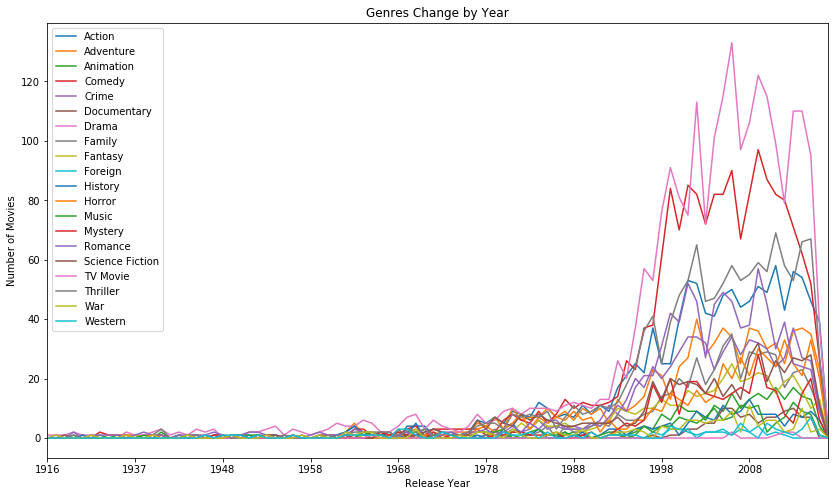

In [19]:
plt.figure(figsize=(14, 8))
ax1 = plt.subplot(1,1,1)
genres_year[genres].plot(kind='line', label='genres', ax=ax1)
plt.title('Genres Change by Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.show()

# 1916-2016 各个种类电影的总数量

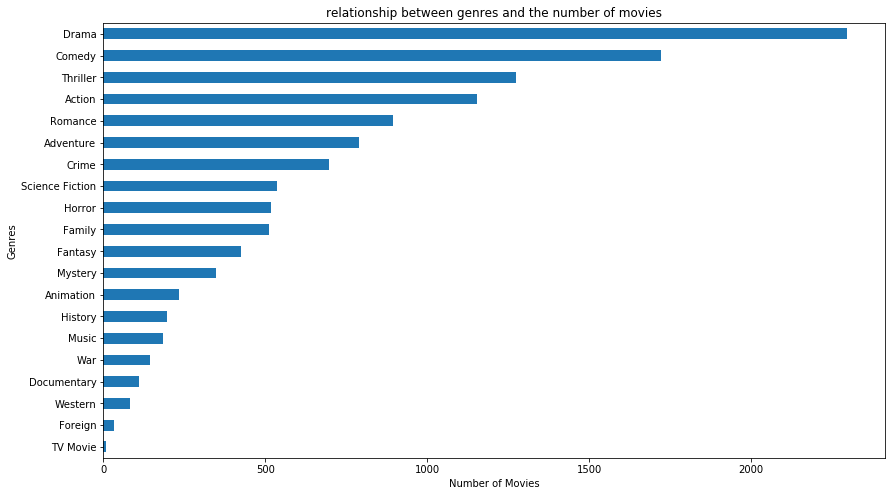

In [20]:
plt.figure(figsize=(14, 8))
ax1 = plt.subplot(1,1,1)
genres_year[genres].sum(axis=0).sort_values(ascending=True)\
                                .plot(kind='barh', ax=ax1)
# plt.legend()
plt.title('relationship between genres and the number of movies')
plt.ylabel('Genres')
plt.xlabel('Number of Movies')
plt.show()

In [21]:
money_df =  movies_df[['release_date', 'budget', 'revenue']].copy()
money_df = money_df.loc[money_df['budget']>0]
money_df = money_df.loc[money_df['revenue']>0]
money_df_year = money_df.groupby('release_date').sum()

# 每年所有的电影预算和收入随时间的变化

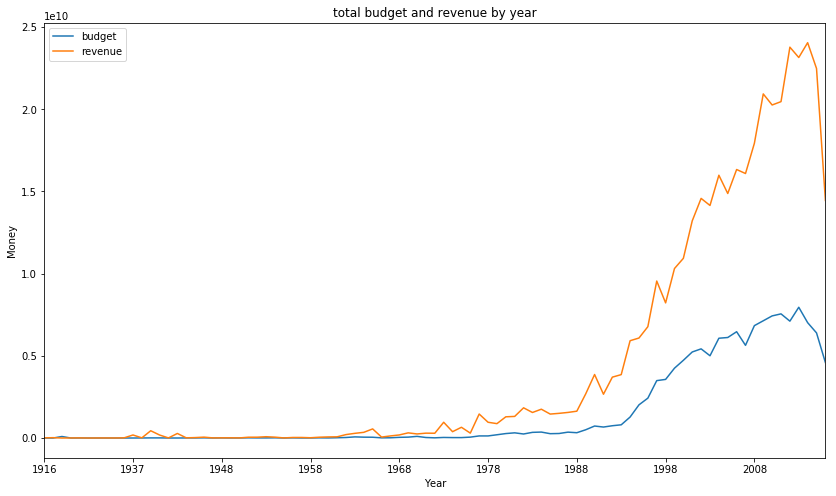

In [24]:
plt.figure(figsize=(14, 8))
ax1 = plt.subplot(1,1,1)
money_df_year.plot(kind='line', ax=ax1)                               
plt.title('total budget and revenue by year')
plt.ylabel('Money')
plt.xlabel('Year')
plt.xticks()
plt.show()

#### 可以看到，电影行业的投入和收入逐年增加，并且收益支出比越来越大，可以赚取更多的利润

# 每年平均一部的电影预算和收入随时间的变化

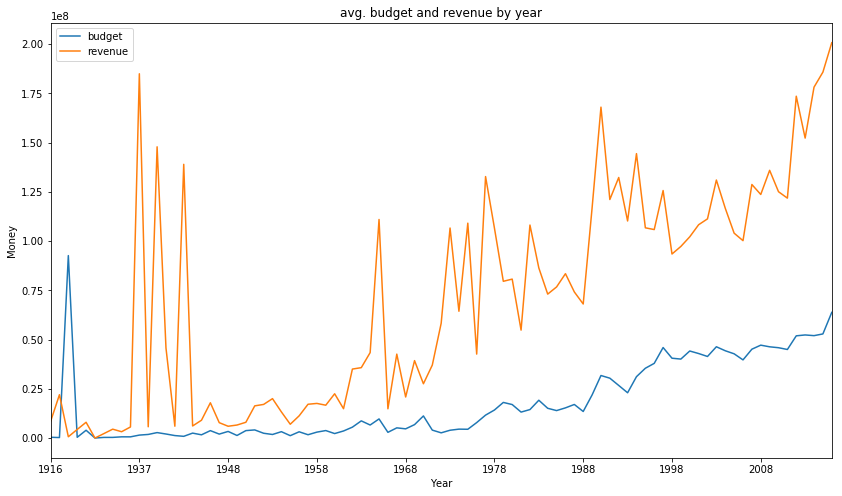

In [23]:
plt.figure(figsize=(14, 8))
ax1 = plt.subplot(1,1,1)
money_df.groupby('release_date').mean().plot(kind='line', ax=ax1)                               
plt.title('avg. budget and revenue by year')
plt.ylabel('Money')
plt.xlabel('Year')
plt.xticks()
plt.show()

# 分析电影关键词，制作词云

In [25]:
keywords = []
for k in movies_df['keywords']:
    keywords += [w.lower() for w in k.split(',')]
words = ' '.join([w for w in keywords if w not in STOPWORDS])
wc = WordCloud(background_color='black', max_words=2000, max_font_size=100, 
               random_state=222, stopwords=set(STOPWORDS))
wc.generate(words)

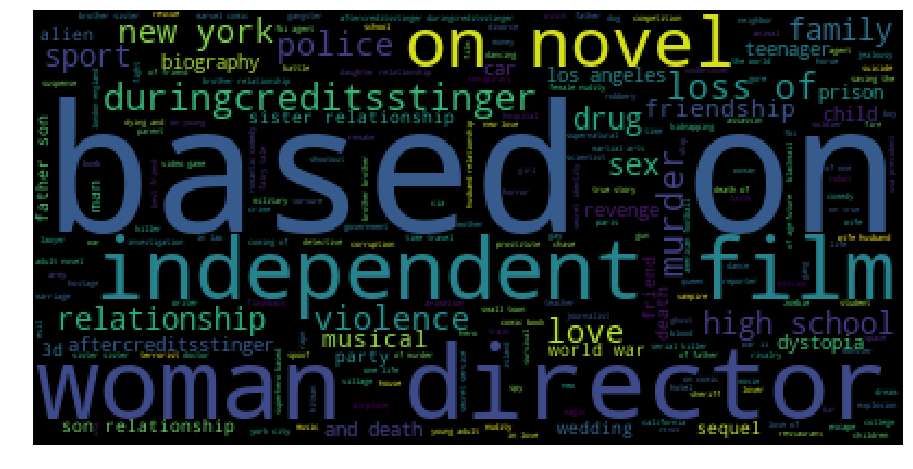

In [26]:
plt.figure(figsize=(16, 8))
plt.imshow(wc)
plt.axis('off')
plt.show()